### Install Dependencies

In [ ]:
%pip install -q -U trl numpy torch peft transformers  datasets bitsandbytes wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
# Login to your wandb -optional
%%bash
wandb login --relogin "<YOUR-API-KEY>"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Import required classes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import wandb
from datasets import load_dataset
from scipy.special import softmax
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix
from transformers import set_seed, TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig

### Load the model

In [ ]:
# Hugging face login
token='<YOUR-API-KEY>'

#quantization configurations
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_qunat_type = "nf4",
    bnb_4bit_compute_dtype = torch.float16,
)

model_name = '<YOUR-Model-Name>'

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.bos_token
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2, # Change according to your case, it is hate / non-hate in our work.
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    token=token
    )
model.config.pad_token_id = tokenizer.pad_token_id

# Initial trainable parameters of our model.
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


num_params = count_trainable_params(model)
formatted_num_params = "{:,}".format(num_params)

print(f"Number of trainable parameters: {formatted_num_params}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at HuggingFaceH4/zephyr-7b-alpha and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of trainable parameters: 131,346,432


# **Testing outputs of the model**

In [ ]:
input_text = ["Hi ra ela unnav?", "Hi ra ela ఉన్నావ్"]

# Tokenize the input text
tokenized = tokenizer(input_text[1], return_tensors="pt", padding=True, truncation=True)

# Pass the tokenized input through the model
output = model(**tokenized)

# Extract the logits
logits = output
logits

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


SequenceClassifierOutputWithPast(loss={'logits': tensor([[ 2.3906, -1.2148]], dtype=torch.float16, grad_fn=<ToCopyBackward0>), 'past_key_values': ((tensor([[[[-8.0017e-02,  1.7044e-02,  2.0862e-01,  ..., -1.3779e+00,
           -2.0469e+00, -2.1797e+00],
          [ 6.6797e+00, -5.0156e+00, -2.8340e+00,  ...,  2.1973e+00,
            1.1387e+00,  4.7900e-01],
          [ 3.2715e+00, -4.6641e+00,  1.2988e-01,  ...,  2.1719e+00,
            1.3779e+00,  7.5244e-01],
          ...,
          [ 1.5898e+00,  5.4961e+00,  4.2812e+00,  ...,  2.0957e+00,
            1.2920e+00,  4.8633e-01],
          [ 6.5391e+00,  4.2969e+00,  3.6699e+00,  ...,  2.1445e+00,
            1.2979e+00,  5.3320e-01],
          [ 5.1641e+00, -5.3320e-01,  4.6875e-01,  ...,  2.0430e+00,
            1.2480e+00,  4.8242e-01]],

         [[ 6.3782e-02,  2.5131e-02,  4.3152e-02,  ...,  3.2148e+00,
           -3.3828e+00,  1.7012e+00],
          [ 1.2842e-01, -3.5571e-01, -2.0386e-02,  ..., -3.1797e+00,
            3.128

### Loading Datasets

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'ML_Project_main_hate_fake.xlsx'
df = pd.read_excel(file_path)

# Select random 100 records for training
train_df = df.sample(n=100, random_state=42)  # You can adjust the random_state for reproducibility

# Rename the relevant columns for training dataframe
train_df = train_df.rename(columns={'Pre_Processed_English_text': 'text', 'Hate': 'labels'})

# Keep only "text" and "labels" columns in the training dataframe
train_df = train_df[['text', 'labels']]

# Save the training dataframe to train.csv
train_df.to_csv('train.csv', index=False)

# Select random 500 records for testing
test_df = df.sample(n=500, random_state=42)  # You can adjust the random_state for reproducibility

# Rename the relevant columns for testing dataframe
test_df = test_df.rename(columns={'Pre_Processed_English_text': 'text', 'Hate': 'labels'})

# Keep only "text" and "labels" columns in the testing dataframe
test_df = test_df[['text', 'labels']]

# Save the testing dataframe to test.csv
test_df.to_csv('test.csv', index=False)


In [ ]:
dataset = load_dataset('csv', data_files={'train': ['train.csv'],
                                          'test':['test.csv']})
def tokenize(examples):
        return tokenizer(examples["text"], truncation=True)

train_dataset = dataset['train'].map(tokenize, batched=True)
test_dataset = dataset['test'].map(tokenize, batched=True)
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 100
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 500
    })
})

### Configure training_args and peft_config

In [ ]:
# Change the parameters and hyper-parameters as per your use case.
epochs = 10
batch_size = 5
gradient_accumulation_steps = 4

# output dir
model_version = "Zephyr_QLoRA"
model_dir = f"{model_version}"

peft_config = LoraConfig(
        r=16,
        lora_alpha=64,
        lora_dropout=0.2,
        bias="none",
        task_type='SEQ_CLS',
        target_modules=[
    "up_proj",
    "o_proj",
    "v_proj",
    "gate_proj",
    "q_proj",
    "down_proj",
    "k_proj"
  ]
)

training_args = TrainingArguments(
        run_name=model_version,
        logging_dir=f"{model_dir}/logs",
        output_dir=model_dir,
        logging_steps=100,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        num_train_epochs=epochs,
        lr_scheduler_type="constant",
        save_strategy="epoch",
        fp16=True,

    )
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

# The parameters after appling LoRA
num_params = count_trainable_params(model)
formatted_num_params = "{:,}".format(num_params)

print(f"Number of trainable parameters: {formatted_num_params}")


---------------------------------------------------------
Number of trainable parameters: 41,951,232
---------------------------------------------------------


### Train the model

In [ ]:

# designing computing metrics as per our use case. (F1-Macro is essential and log-loss is optional)
def compute_metrics(p):
    predictions, labels = p.predictions, p.label_ids
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    macro_f1 = f1_score(labels, predictions, average='macro')

    return {"accuracy": accuracy, "macro_f1": macro_f1}

# configure Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Store progress and track with wandb
wandb.init(
project="<Project-Name>", # Name of the dir you wanted to store this run
name=model_version # Run name
)

# start training
trainer.train()

wandb: Currently logged in as: k-sai-kartheek-reddy. Use `wandb login --relogin` to force relogin


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,No log,3.351930,0.538000,0.501672
2,No log,2.634053,0.580000,0.577811
3,No log,2.123889,0.688000,0.662273
4,No log,2.058008,0.664000,0.650577
5,No log,2.240715,0.678000,0.661934
6,No log,2.380814,0.686000,0.668462
7,No log,2.438197,0.678000,0.661934
8,No log,2.469463,0.674000,0.658354
9,No log,2.488439,0.670000,0.655376
10,No log,2.498606,0.670000,0.655962


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=50, training_loss=0.6432329559326172, metrics={'train_runtime': 797.2478, 'train_samples_per_second': 1.254, 'train_steps_per_second': 0.063, 'total_flos': 2781586050048000.0, 'train_loss': 0.6432329559326172, 'epoch': 10.0})

In [ ]:
# save trained model
trainer.save_model(f'{model_dir}/model')

### Performance of the model on test data

In [ ]:
from tqdm import tqdm
import torch

# Set the model to evaluation mode
model.eval()

# Define batch size for inference
batch_size = 8

# Initialize the list to store predicted class probabilities
predicted = []

# Iterate over the test dataset in batches
for i in tqdm(range(0, len(test_dataset), batch_size)):
    batch_texts = test_dataset['text'][i:i+batch_size]

    # Tokenize the batch and create a batch of data
    tokenized_batch = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)

    # Perform inference on the batch
    with torch.no_grad():
        output = model(**tokenized_batch)

    logits = output.logits.float()

    # Calculate class probabilities
    class_probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Append class probabilities to the list
    predicted.append(class_probabilities)

# Concatenate the predicted probabilities along the batch dimension
concatenated_tensor = torch.cat(predicted)

# Convert the tensor to a NumPy array
predicted_probabilities = concatenated_tensor.detach().cpu().numpy()

# Now you can use 'predicted_probabilities' for further analysis or evaluation


100%|██████████| 63/63 [00:42<00:00,  1.50it/s]


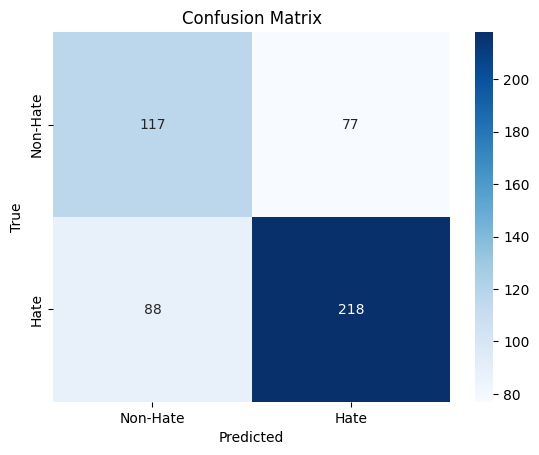

{'F1_Score': 0.6559618680645041, 'Log_Loss': 2.3691260613317238}


In [ ]:
from sklearn.metrics import f1_score, log_loss, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_classification_report(p, y):
    # Convert list of NumPy arrays to a flat NumPy array
    probabilities = np.vstack(p)

    labels = np.array(y)

    # Threshold probabilities if needed
    thresholded_predictions = np.argmax(probabilities, axis=1)

    f1 = f1_score(labels, thresholded_predictions, average='macro')
    logloss = log_loss(labels, probabilities)

    # Confusion matrix
    cm = confusion_matrix(labels, thresholded_predictions)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print({"F1_Score": f1, "Log_Loss": logloss})

# Assuming 'predicted' is a list of NumPy arrays and 'test_dataset['labels']' is a NumPy array
metrics = get_classification_report(predicted, test_dataset['labels'])
